In [13]:
%env CUDA_VISIBLE_DEVICES=6
from pathlib import Path
from pprint import pprint

import numpy as np
import pyarrow.dataset as ds
import torch as ch
import zarr
from torch import Tensor
from tqdm.rich import tqdm

from config.config import Config

cfg = Config()
# cfg.device="cpu"
pprint(cfg)


env: CUDA_VISIBLE_DEVICES=6
Config(device='cuda',
       worker_id=0,
       worker_total=1,
       dry_run=False,
       debug=False,
       output_dir='/raid/pdpl/trak/grads/',
       save_dir='/raid/pdpl/trak/trak_results/',
       write_chunks=1000,
       seed=42,
       proj_dim=2048,
       num_contrastive_samples=50000,
       datasets={'CIFAR100': DatasetConfig(uri='/datasets/cifar100/shards/cifar100-train-{000000..000049}.tar',
                                           uris=None,
                                           size=None,
                                           num_workers=16,
                                           splittable=True,
                                           custom=True),
                 'Food101': DatasetConfig(uri='/datasets/food101/shards/food101-train-{000000..000075}.tar',
                                          uris=None,
                                          size=None,
                                          num_workers=16,
 

In [ ]:
def load_ood_grads(encoder_cfg):
    input_path = str(
        Path(cfg.output_dir)
        / encoder_cfg.name
        / encoder_cfg.ood_dataset_name
        / "data.zarr"
    )
    dataset = zarr.open(input_path)
    uids = np.char.add(
        np.vectorize(lambda x: f"{x:016x}")(dataset.uid["f0"]),
        np.vectorize(lambda x: f"{x:016x}")(dataset.uid["f1"]),
    )
    g = zarr.load(input_path + "/grads")
    out_to_loss = zarr.load(input_path + "/loss_grads")
    # Create a structured array combining both arrays
    dtype = [
        ("uids", uids.dtype),
        ("grads", g.dtype, g.shape[1]),
        (
            "loss_grads",
            out_to_loss.dtype,
        ),
    ]
    combined = np.empty(len(uids), dtype=dtype)
    combined["uids"] = uids
    combined["grads"] = g
    combined["loss_grads"] = out_to_loss

    # Sort in-place based on uids
    combined.sort(order="uids")

    # Extract back the sorted arrays
    uids = ch.tensor(combined["uids"], device="cpu").pin_memory()
    g = ch.tensor(combined["grads"], device="cpu").pin_memory()
    out_to_loss = ch.tensor(combined["loss_grads"], device="cpu").pin_memory()
    return uids, g, out_to_loss


In [19]:
def get_xtx(grads: Tensor, batch_size=20_000) -> Tensor:
    proj_dim = grads.shape[1]
    result = ch.zeros(proj_dim, proj_dim, dtype=grads.dtype, device="cuda")
    blocks = ch.split(grads, split_size_or_sections=batch_size, dim=0)

    for block in tqdm(blocks):
        result += block.T.to("cuda") @ block.to("cuda")

    return result

In [20]:
xtx = get_xtx(ch.tensor(g, device="cpu"))

Output()

/tmp/ipykernel_1634872/1931852164.py:10: TqdmExperimentalWarning: rich is experimental/alpha
  for block in tqdm(blocks):


In [21]:
def get_x_xtx_inv(
    grads: Tensor, xtx: Tensor, lambda_reg=0.0, batch_size=20_000
) -> Tensor:
    xtx_reg = xtx + lambda_reg * ch.eye(
        xtx.size(dim=0), device=xtx.device, dtype=xtx.dtype
    )
    xtx_inv = ch.linalg.inv(xtx_reg.to(ch.float32))

    # center X^TX inverse a bit to avoid numerical issues when going to float16
    xtx_inv /= xtx_inv.abs().mean()
    xtx_inv = xtx_inv.to(grads.dtype)

    grads_blocks = ch.split(grads, split_size_or_sections=batch_size, dim=0)

    # Move xtx_inv to GPU once before the loop
    xtx_inv_gpu = xtx_inv.cuda()

    # Process blocks on GPU
    result_blocks = []
    for block in tqdm(grads_blocks, desc="Processing blocks"):
        # Move block to GPU, compute, then back to CPU
        block_gpu = block.cuda()
        result_gpu = block_gpu @ xtx_inv_gpu
        result_blocks.append(result_gpu.cpu())

    # Concatenate results on CPU
    result = ch.cat(result_blocks)

    return result.to(dtype=grads.dtype)

In [22]:
x_xtx_inv = get_x_xtx_inv(ch.tensor(g, device="cpu"), xtx)

Output()

/tmp/ipykernel_1634872/1614473132.py:20: TqdmExperimentalWarning: rich is experimental/alpha
  for block in tqdm(grads_blocks, desc="Processing blocks"):


In [23]:
features = x_xtx_inv

In [24]:
features_pt = features.pin_memory()

In [25]:
all_scores = {}

In [26]:
from tqdm.rich import trange

In [29]:
def get_indices(target, id: bool = True):
    id_indices_zarr = zarr.open("/raid/pdpl/id_downstream_idx.zarr", mode="r")
    if id:
        return id_indices_zarr[target]["id_indices"]
    else:
        return id_indices_zarr[target]["downstream_indices"]

In [30]:
scores_zarr = zarr.open(
    "/datasets/datacomp/nearest_neighbor_scores.zarr", mode="a"
)
if "trak" not in scores_zarr:
    scores_zarr.create_group("trak")
scores_zarr = scores_zarr["trak"]
# get target features
for target in [
    "fitzpatrick17k",
    "fairvision/dr",
    "fairvision/amd",
    "fairvision/glaucoma",
    "pcam",
    "food101",
    "cifar100",
    "stl10",
]:
    if target in all_scores.keys():
        continue
    if target in scores_zarr:
        all_scores[target] = scores_zarr[target]["id_scores"]
        continue
    input_path = str(Path(cfg.output_dir) / encoder_cfg.name / target)
    dataset_target = ds.dataset(input_path, format="parquet")
    batch_size = 16384
    scanner = dataset_target.scanner(
        columns=["grads", "uid"], batch_size=batch_size
    )
    batches = scanner.to_batches()
    grads_list = []
    uids_list = []
    for batch in tqdm(
        scanner.to_batches(), total=dataset_target.count_rows() // batch_size
    ):
        grads_list.extend(batch.column("grads").to_numpy(zero_copy_only=False))
        uids_list.extend(batch.column("uid").to_numpy(zero_copy_only=False))
    g_target = np.stack(grads_list)
    uids_target = np.stack(uids_list)
    dtype = [
        ("uids", uids_target.dtype),
        ("grads", g_target.dtype, g_target.shape[1]),
    ]
    combined = np.empty(len(uids_target), dtype=dtype)
    combined["uids"] = uids_target
    combined["grads"] = g_target
    combined.sort(order="uids")
    uids_target = combined["uids"]
    g_target = combined["grads"]
    id_indices = get_indices(target, id=False)  # get downstream indices
    g_target_pt = ch.tensor(g_target[id_indices], device="cpu").pin_memory()

    batch_size = 8192 * 2
    scores = []
    for i in trange(0, len(features), batch_size):
        batch = features_pt[i : i + batch_size].cuda()
        batch_scores = ch.mean(batch @ g_target_pt.cuda().T, axis=1)
        scores.append(batch_scores.cpu())
    scores = ch.cat(scores)
    scores = scores * out_to_loss
    if target not in scores_zarr:
        target_group = scores_zarr.create_group(target)
    else:
        target_group = scores_zarr[target]

    # Save the scores
    target_group.array(
        "id_scores", np.array(scores.cpu()), dtype=np.float32, overwrite=True
    )
    all_scores[target] = scores.cpu()


Output()

/tmp/ipykernel_1634872/3380326953.py:32: TqdmExperimentalWarning: rich is experimental/alpha
  for batch in tqdm(


Output()

/git/trak_manual/.venv/lib/python3.11/site-packages/tqdm/rich.py:146: TqdmExperimentalWarning: rich is experimental/alpha
  return tqdm_rich(range(*args), **kwargs)


Output()

Output()

Output()

Output()

Output()

Output()

In [31]:
all_scores.keys()

dict_keys(['fitzpatrick17k', 'fairvision/dr', 'fairvision/amd', 'fairvision/glaucoma', 'pcam', 'food101', 'cifar100', 'stl10'])

In [32]:
import pandas as pd

data = []
for key, scores in all_scores.items():
    mean = scores.mean().item()
    std = scores.std().item()
    data.append({"dataset": key, "mean": mean, "std": std})

df = pd.DataFrame(data)
df = df.sort_values("std", ascending=False)
print(df.to_string(float_format=lambda x: "{:.4f}".format(x)))


               dataset   mean    std
4                 pcam 0.0000 0.0020
2       fairvision/amd 0.0000 0.0016
1        fairvision/dr 0.0000 0.0015
3  fairvision/glaucoma 0.0001 0.0013
0       fitzpatrick17k 0.0000 0.0012
7                stl10 0.0000 0.0011
6             cifar100 0.0000 0.0008
5              food101 0.0000 0.0007


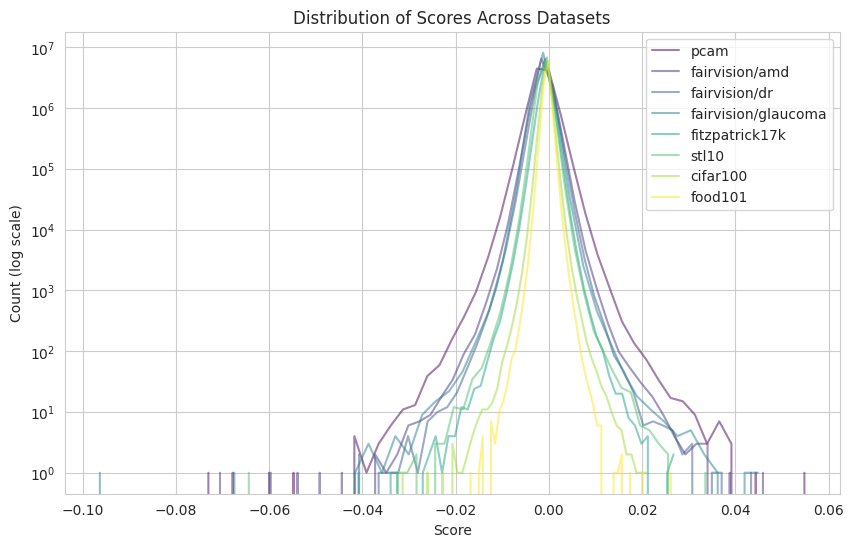

In [33]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid", {"grid.alpha": 0.3})

# Create a continuous color palette with enough colors
num_datasets = len(all_scores)
colors = plt.cm.viridis(np.linspace(0, 1, num_datasets))


def compute_histogram(data, bins=50):
    hist, bin_edges = jnp.histogram(data, bins=bins)
    return hist, bin_edges


# Plot in order of standard deviation from df
for i, row in enumerate(df.itertuples()):
    key = row.dataset
    scores = all_scores[key]
    scores_np = jnp.array(scores.numpy())
    hist, bins = compute_histogram(scores_np)

    # Convert back to numpy for seaborn plotting
    hist = hist.block_until_ready()
    sns.lineplot(x=bins[:-1], y=hist, alpha=0.5, label=key, color=colors[i])
    plt.yscale("log")

plt.title("Distribution of Scores Across Datasets")
plt.xlabel("Score")
plt.ylabel("Count (log scale)")
plt.legend()
plt.show()

In [40]:
# from trak.utils import get_matrix_mult_blockwise

# full_scores = get_matrix_mult_blockwise(
#     features, ch.tensor(g_target, device="cpu"), ch.float16, bs=2048
# )
